In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#convolutional model
class ConvModel(nn.Module):
    def __init__(self, output_features=1, input_channels=4, conv_out_channels=16, l2=10, l3=8, kernel_size=3, input_size=28):
        super(ConvModel, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv1d(input_channels, conv_out_channels, kernel_size=kernel_size)
        # Calculate the size after convolution (simplified calculation assuming stride=1 and padding=0)
        conv_output_size = input_size - kernel_size + 1
        # Fully connected layer after flattening the conv output
        #self.fc1 = nn.Linear(conv_out_channels * (conv_output_size ** 2), output_features)
        self.fc1 = nn.Linear(conv_out_channels, l2)
        self.fc2 = nn.Linear(l2, l3)

        self.out = nn.Linear(l3, output_features)
    def forward(self, x):
        # Apply convolution
        x = F.relu(self.conv1(x))
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        # Output layer
        x = self.fc1(x)
        x = F.relu(self.fc2(x))

        x = F.relu(self.out(x))
        return x

In [ ]:
#pure linear model
class LinearModel(nn.Module):
    def __init__(self, output_features=1, input_features=2, l1=9, l2=10, l3=15, l4=12):
        super(LinearModel, self).__init__()

        self.fc1 = nn.Linear(input_features, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, l4)

        self.out1 = nn.Linear(l4, output_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = self.out1(x)
        return x

In [ ]:
#Load data
githuburl = "https://github.com/nikojlieto/antennann/raw/main/data/5tags-circle-antennasweep%20(calculations%20included).csv"
my_df = pd.read_csv(githuburl)

In [ ]:
list(my_df.columns)

In [ ]:
#tmp
#print(new_X)

In [ ]:
#Data preparation
#input to be placed in X
model_type = "Conv"
num_scans = 4

input_columns = ['phase (radians)', 'prx deoscillated moving parts ()', 'doppler ()']
X = my_df[input_columns].values
#output to be placed in y
output_columns = ['New R from Prx']
y = my_df[output_columns].values
tags = my_df['epc96'].values
#select model to use

if model_type == "Conv":
    #setup X and y for Conv net
    #using slices of scans on the same tag
    new_X = []
    new_y = []
    i = 0
    while((i+num_scans-1) < len(my_df)):
        if(tags[i] == tags[i+(num_scans - 1)]):
            new_X.append(X[i:i+num_scans])
            #new_y.append(y[i:i+num_scans])
            new_y.append(y[i+num_scans-1])
        i += 1
        #i += num_scans
    X = np.array(new_X)
    #take avg here for each sample
    y = np.array(new_y)

    print("number of samples=", len(y), "\nscans per sample =", num_scans)

elif model_type == "Linear":
    pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

#print(X_train)
#print(y_train)

number of samples= 49869 
scans per sample = 4


In [ ]:
#Model instantiation

if model_type == "Linear":
    model = LinearModel(output_features=1, input_features=len(input_columns))
elif model_type == "Conv":
    model = ConvModel(output_features=1, input_channels=num_scans, conv_out_channels=num_scans**2)


criterion = nn.MSELoss()  # Changed to MSE for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#Training loop

epochs = 2000
losses = []
for i in range(epochs):
    y_pred = model(X_train)
    #print(y_pred)
    #print(y_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    if i % 100 == 0:
        #print(y_pred)
        print(f'Epoch: {i}\t and loss: {np.format_float_scientific(loss.item(), precision=6, unique=False)}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(f'Epoch: {i}\t and loss: {np.format_float_scientific(loss.item(), precision=3, unique=False)}')

Epoch: 0	 and loss: 2.136182e+07
Epoch: 100	 and loss: 2.101448e+07
Epoch: 200	 and loss: 2.069009e+07
Epoch: 300	 and loss: 2.039205e+07
Epoch: 400	 and loss: 2.012341e+07
Epoch: 500	 and loss: 1.988653e+07
Epoch: 600	 and loss: 1.968267e+07
Epoch: 700	 and loss: 1.951164e+07
Epoch: 800	 and loss: 1.937225e+07
Epoch: 900	 and loss: 1.926233e+07
Epoch: 1000	 and loss: 1.917788e+07
Epoch: 1100	 and loss: 1.911560e+07
Epoch: 1200	 and loss: 1.907182e+07
Epoch: 1300	 and loss: 1.904218e+07


KeyboardInterrupt: 

Conv
Test Loss: 1.966156e+07

threshold = 4 %
ratio within thresh = 0.9337611122251186
highest percent error = 8.216708975435749
avg error = 3079.05407392554
avg percent error = 1.9351756889674254
max percent error = 8.216708975435749


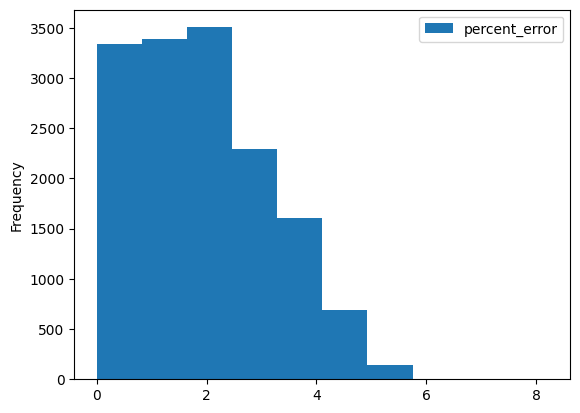

In [ ]:
#Model evaluation
print(model_type)
thresh = 4 #percentage threshold of allowed error to check beyond
count = 0
cum_diff = 0
cum_diff_percent = 0
errors_percent = []
max_percent_error = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_eval = model(X_test)
    loss = criterion(y_eval, y_test)
    print(f'Test Loss: {np.format_float_scientific(loss.item(), precision=6, unique=False)}\n')

    for i in range(len(y_eval)):
      #print("eval", y_eval[i], "\n test", y_test[i], "\n difference", y_eval[i] - y_test[i])
      diff = (int(y_eval[i]) - int(y_test[i]))
      if (diff < 0):
          diff = -diff
      percent_diff = 100 * (diff / int(y_test[i]))
      cum_diff += diff
      cum_diff_percent += percent_diff
      errors_percent.append(percent_diff)
      if(percent_diff > thresh):
          #print("eval", y_eval[i], "\n test", y_test[i], "\n difference", y_eval[i] - y_test[i])
          count = count + 1
      if(percent_diff > max_percent_error):
         max_percent_error = percent_diff
    print("threshold =", thresh, "%")
    #print("count beyond thresh =", count, "ratio =", count/len(y_eval))
    print("ratio within thresh =", 1 - count/len(y_eval))
    print("highest percent error =", max_percent_error)
    print("avg error =", cum_diff / len(y_eval))
    print("avg percent error =", cum_diff_percent / len(y_eval))
    print("max percent error =", max_percent_error)
    df_eval = pd.DataFrame({"percent_error": errors_percent})
    ax = df_eval.plot.hist()
    #std deviation of 5 tag set R from prx = 97,915

In [ ]:
#Save the trained model
torch.save(model.state_dict(), 'trained_model.pt')